In [1]:
import torch
from binNF.normalizing_flows.manager import *
import matplotlib.pyplot as plt
import numpy as np


In [2]:
def step(x):
    a=torch.zeros_like(x[:,0])
    b=torch.ones_like(x[:,0])
   
    return torch.where(torch.max(abs(x[:,0]), abs(x[:,1]))>1,a,b)

def gaussian(x):
    return torch.exp( -((x[:,0]-2)**2+(x[:,1]-2)**2)/(1**2)) 

def gaussianb(x):
    return torch.exp( -(x)**2)[:,0]

def gaussianbnp(x):
    return np.exp( -((x[:,0]+1)**2+(x[:,1])**2) )

def gaussiannp(x):
    return np.exp( -(x[:,0])**2 )

def con(x):
    y=torch.empty(x.shape[0])
    return y.fill_(5)

def sin(x):
    return 2+torch.sin(x[:,1])

def lin(x):
    return 0.2*x[:,0]+0.5

def sinnp(x):
    return 2+np.sin(x[:,1])

def tanp(r):
    return (1+((torch.tan((r-0.5)*np.pi))**2))*np.pi

In [3]:
n_flow = 2      # number of dimensions


# We define our NormalizingFlow object 
NF =  AffineManager(n_flow=n_flow)



In [11]:
#The model is created
NF.create_model(n_pass_through=1,n_cells=2, NN=[100,100,100,100, 100], roll_step=1)
optim = torch.optim.SGD(NF._model.parameters(),lr=5e-3, weight_decay=1e-7) 



#normal initial distrib: much more stable, in general better results, 
#but can be overtrained/tends to collapse to delta function
# tan: results in general worse, fails at distributions with small (std<1) 
#but more stable for wide distributions. Also tends to collapse to delta


In [13]:

history = NF._train_variance_forward(gaussian,epochs=300,batch_size=20000,optimizer_object=optim, logdir="./logs/tmp/")
#1e-7 120 1d uniform (always 150) (wot) 
#0.4 e-7 600 2d uniform (wot)  (smaller lr and shorter for wide gaussians)
#0.5e-7, 90 1d uniform (wt)  
#0.4 e-7 600 2d uniform (wt) 
# 5e-3 60 1d normal wot   
#5e-3 100 2d normal wot for std=1 2e-2 400 for std 0.3 

0.07116804271936417


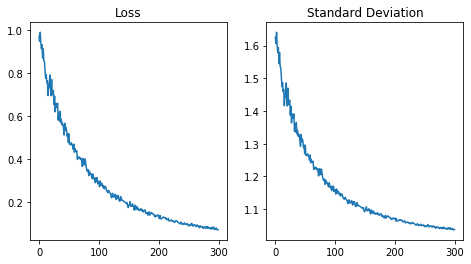

In [14]:

losses=[]
for key, value in history.items():
    losses.append(value["loss"])

fig = plt.figure(figsize=(12, 4))
a1=fig.add_subplot(131)
plt.plot(losses)
print(min(losses))
a1.title.set_text('Loss')
a2=fig.add_subplot(132)
plt.plot(np.sqrt(np.exp(losses)))
a2.title.set_text('Standard Deviation')






In [14]:
w = torch.empty(20, NF.n_flow)
torch.nn.init.normal_(w)

print("W")
print(w)
                    #print(self.format_input(w).requires_grad)
print("with jacob")                  # Output a sample of (phase-space point, forward Jacobian)
print(NF.format_input(w))

#print("mapped")
#print(NF.format_input(100*torch.tan((w-0.5)*(np.pi))))
XJ=NF.model(NF.format_input(w))


                    # Separate the points and their Jacobians:
print("XJ")
print(XJ)# This sample is fixed, we optimize the Jacobian

XJ2=NF.best_model(NF.format_input(w))


                    # Separate the points and their Jacobians:
print("XJ2")
print(XJ2)

"""
f=gaussian
print("f(x)")
print(f(X))


print("fXJ")
print(torch.mul(f(X), XJ[:, -1]))

print("loss without jac")
print(torch.mean(f(X)**2))

print("squared mean")
print(torch.mean(f(X))**2)

print("loss")
print(torch.mean(torch.mul(f(X), XJ[:, -1])**2))

"""

W
tensor([[-1.3079, -0.2136],
        [-0.7593,  0.2870],
        [ 0.4836,  1.7866],
        [ 1.2398, -0.5764],
        [-1.8998, -0.1249],
        [ 0.4602, -0.8308],
        [-0.3608,  0.2317],
        [ 0.2379, -0.0549],
        [-0.2961,  0.0577],
        [-1.8820,  0.1793],
        [ 1.2616, -0.9129],
        [-0.0543,  0.9980],
        [ 1.8162,  0.7931],
        [-1.4644, -1.0949],
        [-0.1942,  0.1874],
        [ 0.1310,  0.2285],
        [-2.3652, -0.8737],
        [ 1.3062,  0.8337],
        [ 2.0568, -1.0228],
        [ 2.5188, -0.4670]])
with jacob
tensor([[-1.3079, -0.2136,  1.0000],
        [-0.7593,  0.2870,  1.0000],
        [ 0.4836,  1.7866,  1.0000],
        [ 1.2398, -0.5764,  1.0000],
        [-1.8998, -0.1249,  1.0000],
        [ 0.4602, -0.8308,  1.0000],
        [-0.3608,  0.2317,  1.0000],
        [ 0.2379, -0.0549,  1.0000],
        [-0.2961,  0.0577,  1.0000],
        [-1.8820,  0.1793,  1.0000],
        [ 1.2616, -0.9129,  1.0000],
        [-0.0543,  

'\nf=gaussian\nprint("f(x)")\nprint(f(X))\n\n\nprint("fXJ")\nprint(torch.mul(f(X), XJ[:, -1]))\n\nprint("loss without jac")\nprint(torch.mean(f(X)**2))\n\nprint("squared mean")\nprint(torch.mean(f(X))**2)\n\nprint("loss")\nprint(torch.mean(torch.mul(f(X), XJ[:, -1])**2))\n\n'

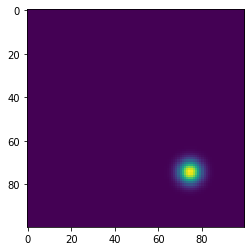

In [49]:
xs = np.linspace(-10,10,100)
ys = np.linspace(10,-10,100) # in images the y axis is inverted
Xs,Ys = np.meshgrid(xs,ys)
zs=gaussianbnp(np.array(list(zip(Xs.reshape(100*100),Ys.reshape(100*100)))).astype(np.float32)).reshape(100,100)
plt.imshow(zs)
plt.show()

In [31]:
print("reset")
NF.create_model(n_pass_through=1,n_cells=1, nn_width=2, NN=[20,20,20], roll_step=1)

w = torch.empty(10000, NF.n_flow, requires_grad=True)
torch.nn.init.uniform_(w,0,1)

print("W")
print(w)
                    #print(self.format_input(w).requires_grad)
print("with jacob")                  # Output a sample of (phase-space point, forward Jacobian)
print(NF.format_input(w))
XJ = NF.model(NF.format_input(w))

                    # Separate the points and their Jacobians:
print("XJ")
print(XJ)# This sample is fixed, we optimize the Jacobian
X = ((XJ[:, :-1]).detach())
print("X")
print(X)
print("diff")
print(X[:,0]-w[:,1])
print("f(x)")
print(sin(X))

print("fXJ")
print(torch.mul(sin(X), XJ[:, -1]))

reset
W
tensor([[0.9578, 0.9368],
        [0.3170, 0.6490],
        [0.1292, 0.2823],
        ...,
        [0.2792, 0.5616],
        [0.6719, 0.1296],
        [0.9155, 0.5293]], requires_grad=True)
with jacob
tensor([[0.9578, 0.9368, 1.0000],
        [0.3170, 0.6490, 1.0000],
        [0.1292, 0.2823, 1.0000],
        ...,
        [0.2792, 0.5616, 1.0000],
        [0.6719, 0.1296, 1.0000],
        [0.9155, 0.5293, 1.0000]], grad_fn=<CatBackward>)
XJ
tensor([[ 0.1796,  0.9578,  0.4919],
        [ 0.0680,  0.3170,  0.4914],
        [-0.1451,  0.1292,  0.4898],
        ...,
        [ 0.0200,  0.2792,  0.4911],
        [-0.2019,  0.6719,  0.4921],
        [-0.0193,  0.9155,  0.4919]], grad_fn=<CatBackward>)
X
tensor([[ 0.1796,  0.9578],
        [ 0.0680,  0.3170],
        [-0.1451,  0.1292],
        ...,
        [ 0.0200,  0.2792],
        [-0.2019,  0.6719],
        [-0.0193,  0.9155]])
diff
tensor([-0.7571, -0.5810, -0.4274,  ..., -0.5416, -0.3315, -0.5486],
       grad_fn=<SubBackward0>)

In [ ]:
"""
#a4=fig.add_subplot(143)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(X[:,0],X[:,1],X[:,2])
#plt.2d(X[:,0],X[:,1],X[:,2])
#ax.set_aspect(aspect=1.)
ax.title.set_text('Jacobian after training')
ax.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    left=True,         # ticks along the top edge are off
    labelbottom=True,
    labelleft=True)


NF.create_model(n_pass_through=1,n_cells=1, nn_width=2, NN=[5], roll_step=1)
rcParams['axes.labelpad'] = 800
z = torch.empty((10000,2)) 
torch.nn.init.uniform_(z,0,1)

w=NF.format_input(z)
X=NF.model(w).data.numpy()
fig = plt.figure()
ax1 = fig.add_subplot(211, projection='3d')
ax1.scatter3D(X[:,0],X[:,1],X[:,2])
#plt.2d(X[:,0],X[:,1],X[:,2])
#ax.set_aspect(aspect=1.)
ax1.title.set_text('Jacobian before training')
ax1.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    left=True,         # ticks along the top edge are off
    labelbottom=True,
    labelleft=True)
#ax1.auto_scale_xyz([0.5, 2], [0, 1], [1.55, 1.75])
ax1.xaxis._axinfo['label']['space_factor'] = 4.8
ax1.zaxis._axinfo['label']['space_factor'] = 8.8
rcParams['axes.labelpad'] = 80

print("\n")
"""

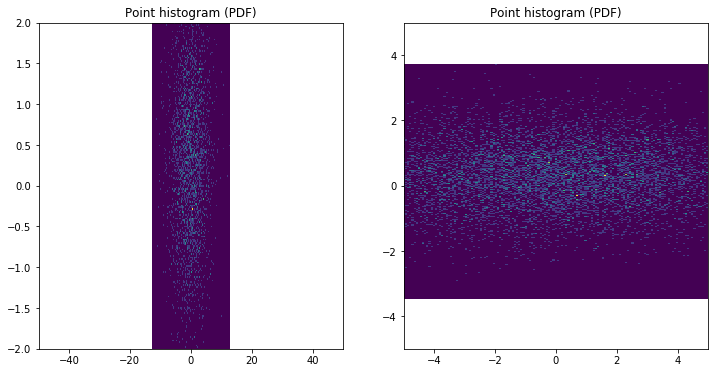

In [15]:
w = torch.empty((250,2)) 
torch.nn.init.uniform_(w,0,1)
q = torch.empty((12100,2)) 
torch.nn.init.normal_(q,std=10)
z=150*torch.tan((w-0.5)*(np.pi))

#more bins than points= fine grid
Y=NF.format_input(q)
X=NF.model(Y)
XX=NF.best_model(Y)
#Z=(torch.atan(X)/np.pi+0.5).data.numpy()
#print(Z)
X=X.data.numpy()
XX=XX.data.numpy()
z=z.data.numpy()
#a3=fig.add_subplot(133)
fig = plt.figure(figsize=(12, 6))
a3=fig.add_subplot(121)

plt.hist2d(X[:,0],X[:,1],bins=360)
axes = plt.gca()
axes.set_xlim([-50,50]) 
axes.set_ylim([-2,2])
#a3.set_aspect(aspect=1.)


a3.title.set_text('Point histogram (PDF)')
a3.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    left=True,         # ticks along the top edge are off
    labelbottom=True,
    labelleft=True)


#fig = plt.figure(figsize=(6, 6))
a4=fig.add_subplot(122)
#plt.hist2d(X[:,0],X[:,1],bins=2500)
#Q=[[]]
#Q=[[-1,-1,-1],[2,2,2]]
#Q[:,1]=[,]
#Q=np.ones((10,2))
#Q[:,0]*=-1
plt.hist2d(XX[:,0],XX[:,1],bins=360)
axes = plt.gca()
axes.set_xlim([-5,5])
axes.set_ylim([-5,5])
#a3.set_aspect(aspect=1.)


a4.title.set_text('Point histogram (PDF)')
a4.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    left=True,         # ticks along the top edge are off
    labelbottom=True,
    labelleft=True)



In [48]:
w = torch.empty(20, 2)
torch.nn.init.normal_(w, std=100)

tensor([[ 124.0116,   47.9657],
        [  -7.4994, -213.4038],
        [  67.7636,  -32.0429],
        [ -42.4372,  -10.8968],
        [ -33.5290,    6.3961],
        [  13.0762,  -38.7510],
        [  83.4277,  -12.8562],
        [ -82.8009,  -22.0921],
        [  11.4701,  154.7312],
        [-127.1577,  -81.6875],
        [  43.4944,   21.7519],
        [ 182.8632,   95.6407],
        [-137.9283,  -93.3104],
        [  41.1783,  103.4374],
        [-113.1125,  -20.7664],
        [ 101.5151,   29.5386],
        [ -55.7257,   81.6997],
        [ -72.3741,   35.4625],
        [  25.8046,   -1.5254],
        [-172.8428,   73.4215]])